# Using Current Data To Make Recommendations
### Model #1: (Classification - Fully Paid vs. Default) 
### Model #2: ( Regression - Annualized Return %)

In [54]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from functions_and_objects import (impute_means_zeros_maxs_X,parse_percentage,
                                   clean_new_LC_data_classification_current,clean_LC_data_classification_eval,
                                   preprocessing_current, preprocessing_future_test, columns_list, 
                                   nan_max_cols, nan_mean_cols, nan_zero_cols, dtype,
                                   one_hot_encode_current, concat_X_and_6ohe_dfs,
                                   prep_all_df_for_classification, view_columns_by_number_of_rows_that_have_nan)
from functions_and_objects import (prep_df_for_regression_current,
                                   calc_annu_return,impute_annu_return_to_y,
                                   scale_current)

import joblib
from sklearn.metrics import (accuracy_score, precision_score, recall_score, #classification
                             f1_score, roc_auc_score, roc_curve,precision_recall_fscore_support, #classification
                             r2_score,mean_squared_error) #regression

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import New Data from 2018-2019

- These files contain complete loan data for all loans issued through the time period stated, including the current loan status (Current, Late, Fully Paid, etc.) and latest payment information. The file containing loan data through the "present" contains complete loan data for all loans issued through the previous completed calendar quarter.

In [3]:
raw_q12019 = pd.read_csv('~/peervest/lc_data/LoanStats_securev1_2019Q1.csv',header=1)
raw_q42018 = pd.read_csv('~/peervest/lc_data/LoanStats_securev1_2018Q4.csv',header=1)
raw_q32018 = pd.read_csv('~/peervest/lc_data/LoanStats_securev1_2018Q3.csv',header=1)
raw_q22018 = pd.read_csv('~/peervest/lc_data/LoanStats_securev1_2018Q2.csv',header=1)
raw_q12018 = pd.read_csv('~/peervest/lc_data/LoanStats_securev1_2018Q1.csv',header=1)
dfs_list = [raw_q42018,
            raw_q32018,
            raw_q22018,
            raw_q12018]

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,144,145,146) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,129,130,131,134,135,136,139,144,145,146) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Clean Data

In [4]:
#use cleaning function "current" because 
#we're making predictions on current loans
#rather than using labelled/completed data

clean_lc_df_current = clean_new_LC_data_classification_current(dfs_list) #takes in dfs_list, outputs clean_lc_df


/home/jupyter/peervest/functions_and_objects.py:217: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  raw_lc_df['earliest_cr_line'] = pd.to_timedelta(pd.to_datetime(raw_lc_df['earliest_cr_line'])).dt.days


In [41]:
clean_lc_df_future = clean_LC_data_classification_eval(dfs_list)
X_future, y_future = preprocessing_future_test(clean_lc_df_future)
(ohe_home_ownership, ohe_purpose, ohe_zip_code, 
 ohe_application_type, ohe_sub_grade, ohe_emp_title_2) = one_hot_encode_current(X_future)
X_future_classif = concat_X_and_6ohe_dfs(X_future, ohe_home_ownership, ohe_purpose, ohe_zip_code, 
                                         ohe_application_type, ohe_sub_grade, ohe_emp_title_2)

/home/jupyter/peervest/functions_and_objects.py:189: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  raw_lc_df['earliest_cr_line'] = pd.to_timedelta(pd.to_datetime(raw_lc_df['earliest_cr_line'])).dt.days
/home/jupyter/peervest/functions_and_objects.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  y_future['loan_status'] = y_future['loan_status'].astype(int)


In [43]:
X_future_classif.set_index('index',inplace=True)
prep_all_df_for_classification(X_future_classif)

In [55]:
view_columns_by_number_of_rows_that_have_nan(X_future_classif)

Series([], dtype: float64)

In [56]:
view_columns_by_number_of_rows_that_have_nan(X_current_classif)

Series([], dtype: float64)

### Preprocess, no train-test-split: entire dataset is our test data

In [5]:
# takes in clean_lc_df_current, outputs X_current, y_current
X_current, y_current = preprocessing_current(clean_lc_df_current)

In [6]:
print(X_current.shape)
print(y_current.shape)

(361423, 101)
(361423, 1)


### One Hot Encode for both Models

In [7]:
(ohe_home_ownership, ohe_purpose, ohe_zip_code, 
 ohe_application_type, ohe_sub_grade, ohe_emp_title_2) = one_hot_encode_current(X_current)

In [8]:
X_current_classif = concat_X_and_6ohe_dfs(X_current, ohe_home_ownership, ohe_purpose, ohe_zip_code,
                                          ohe_application_type, ohe_sub_grade, ohe_emp_title_2)
X_current_regr = concat_X_and_6ohe_dfs(X_current, ohe_home_ownership, ohe_purpose, ohe_zip_code, 
                                       ohe_application_type, ohe_sub_grade, ohe_emp_title_2)

In [9]:
print(X_current_classif.shape)
print(X_current_regr.shape)

(361423, 1133)
(361423, 1133)


### Prep X_current for Classification

- reset index

In [10]:
X_current_classif.set_index('index',inplace=True)

- drop non-numeric & OHE source columns

In [11]:
prep_all_df_for_classification(X_current_classif) #drops columns inplace

In [12]:
X_current_classif.shape

(361423, 1124)

### X_current is ready to input into Classification Model

In [13]:
print(y_current.shape)
y_current.head()

(361423, 1)


,class_pred
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


###### Load Model JobLib

In [14]:
loaded_log_reg_v1 = joblib.load('log_reg_v1.joblib')

In [15]:
current_class_preds = loaded_log_reg_v1.predict(X_current_classif)
current_class_preds_proba = loaded_log_reg_v1.predict_proba(X_current_classif)

In [16]:
len(current_class_preds_proba)

361423

In [36]:
loaded_log_reg_v1.classes_

array([0, 1])

In [37]:
current_class_preds_proba[:,0]

array([1., 1., 1., ..., 1., 1., 1.])

In [19]:
y_current['prob_default'] = current_class_preds_proba[:,0]

###### ------- Scratch Work

(array([1.33400e+03, 1.40000e+01, 1.40000e+01, 1.30000e+01, 4.00000e+00,
        7.00000e+00, 2.00000e+00, 7.00000e+00, 1.00000e+01, 1.00000e+01,
        6.00000e+00, 5.00000e+00, 6.00000e+00, 4.00000e+00, 5.00000e+00,
        4.00000e+00, 1.40000e+01, 1.60000e+01, 2.60000e+01, 3.59922e+05]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 20 Patch objects>)

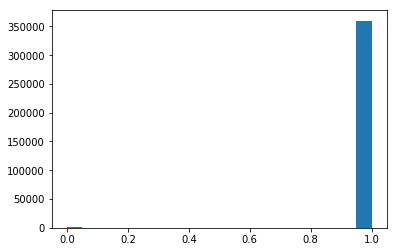

In [71]:
plt.hist(y_current['prob_default'],bins=20,range=(0,1))

In [73]:
low_prob_default_indices = y_current[y_current['prob_default'] <0.1].index

In [75]:
low_prob_default_indices

Int64Index([   627,    713,    746,   1136,   1162,   1181,   1565,   2200,
              2284,   2992,
            ...
            358160, 358298, 358385, 358699, 358856, 358875, 359535, 359640,
            360711, 361188],
           dtype='int64', length=1348)

In [77]:
pd.set_option('display.expand_frame_repr', False)

In [83]:
y_future['prob_default'] = loaded_log_reg_v1.predict_proba(X_future_classif)[:,0]
low_prob_default_indices_future = y_future[y_future['prob_default'] <0.1].index
low_prob_default_indices_future

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Int64Index([    0,     1,     2,     3,     4,     6,     7,     8,     9,
               10,
            ...
            68104, 68105, 68108, 68109, 68110, 68112, 68113, 68115, 68117,
            68118],
           dtype='int64', length=56676)

In [81]:
X_current_classif.iloc[low_prob_default_indices,:].head(20).T

index,627,713,746,1136,1162,1181,1565,2200,2284,2992,3044,3055,3788,4414,4810,4986,5423,5660,6079,6191
loan_amnt,16000.000000,8000.000000,10000.000000,25000.000000,14000.000000,12000.000000,40000.000000,10000.000000,25000.000000,7000.000000,4900.000000,8000.000000,4400.000000,21000.000000,15000.000000,3600.000000,20000.000000,21000.000000,2000.000000,11000.000000
funded_amnt,16000.000000,8000.000000,10000.000000,25000.000000,14000.000000,12000.000000,40000.000000,10000.000000,25000.000000,7000.000000,4900.000000,8000.000000,4400.000000,21000.000000,15000.000000,3600.000000,20000.000000,21000.000000,2000.000000,11000.000000
total_pymnt,16256.254040,8331.832403,10106.200000,25793.804831,14182.640233,12404.767360,42276.862566,10343.253448,27479.695792,7348.459340,5055.310985,8251.970606,4342.850000,22371.263051,15352.830000,3717.991901,20461.660000,22143.340925,2045.034885,11484.262442
int_rate,0.064600,0.118000,0.161400,0.081900,0.161400,0.088100,0.144700,0.088100,0.243700,0.129800,0.081900,0.081900,0.070200,0.169100,0.070200,0.081900,0.169100,0.135600,0.081900,0.107200
installment,490.100000,264.960000,243.930000,785.610000,493.170000,380.540000,940.510000,317.120000,724.580000,235.800000,153.980000,251.400000,135.900000,747.770000,463.300000,113.130000,496.090000,713.260000,62.850000,237.640000
emp_length,4.000000,2.000000,1.000000,8.000000,4.000000,1.000000,1.000000,4.000000,9.000000,1.000000,5.000000,4.000000,8.000000,5.000000,3.000000,1.000000,2.000000,5.000000,0.000000,1.000000
annual_inc,43000.000000,22000.000000,173500.000000,135000.000000,44000.000000,86000.000000,220000.000000,55000.000000,55000.000000,125000.000000,75000.000000,65000.000000,78000.000000,57000.000000,150000.000000,61000.000000,64000.000000,50000.000000,41155.000000,101000.000000
dti,5.860000,16.260000,7.230000,13.480000,19.940000,13.350000,10.810000,16.060000,9.750000,11.400000,8.620000,7.880000,4.260000,21.350000,15.060000,15.330000,13.010000,21.990000,13.980000,5.350000
delinq_2yrs,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
earliest_cr_line,12753.000000,16375.000000,10227.000000,6482.000000,10988.000000,13879.000000,15765.000000,13180.000000,6909.000000,8705.000000,12662.000000,15614.000000,2099.000000,12478.000000,13604.000000,8460.000000,8886.000000,13604.000000,13514.000000,12204.000000


(array([5.6666e+04, 1.0000e+01, 6.0000e+00, 4.0000e+00, 2.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 1.0889e+04]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 20 Patch objects>)

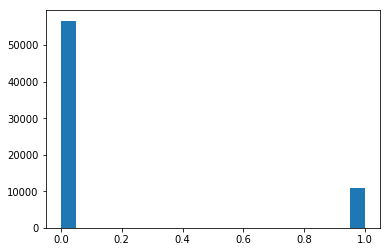

In [63]:
plt.hist(loaded_log_reg_v1.predict_proba(X_future_classif)[:,0],bins=20,range=(0,1))

In [64]:
loaded_log_reg_v1.predict_proba(X_future_classif)[:,0]

array([[2.89095603e-003, 9.97109044e-001],
       [1.80524177e-006, 9.99998195e-001],
       [1.37538903e-007, 9.99999862e-001],
       ...,
       [1.00000000e+000, 6.90269850e-235],
       [2.59676371e-004, 9.99740324e-001],
       [4.60361519e-004, 9.99539638e-001]])

###### ----------

### Prep X_current for Regression

- reset index

In [20]:
X_current_regr.set_index('index',inplace=True)

- calculate annual return & create new target dataframe

In [21]:
# returns the annualized return column as a DF (y_future_regr) & both target columns as a dataframe (y_future)
y_current_regr, y_current = impute_annu_return_to_y(X_current_regr,y_current)

- drop non-numeric & OHE source columns

In [22]:
prep_df_for_regression_current(X_current_regr)

In [23]:
X_current_regr_scaled = scale_current(X_current_regr)

In [24]:
X_current_regr_scaled.shape

(361423, 1124)

###### Load Ridge Regression Model JobLib

In [25]:
loaded_ridge_reg_v1 = joblib.load('ridge_lin_reg_v1.joblib')

In [26]:
current_return_preds = loaded_ridge_reg_v1.predict(X_current_regr_scaled)

- Positive annu_return values where loan_status==0 likely indicates a successful debt collection process

In [29]:
current_return_preds

array([[ 0.01616499],
       [-0.02710525],
       [ 0.25884256],
       ...,
       [ 0.09232062],
       [ 0.2400825 ],
       [ 0.29361946]])

In [30]:
y_predictions = y_current
y_predictions['return_preds'] = current_return_preds

In [31]:
y_predictions.drop(columns=['class_pred'],inplace=True)

In [34]:
y_predictions.describe()

,prob_default,annu_return,return_preds
count,3.614230e+05,361423.000000,361423.000000
mean,9.960953e-01,-0.709949,-0.014839
std,6.171660e-02,0.200744,0.266632
min,1.031910e-07,-0.997731,-1.025594
25%,1.000000e+00,-0.892570,-0.142537
50%,1.000000e+00,-0.723050,-0.007294
75%,1.000000e+00,-0.554626,0.098417
max,1.000000e+00,0.281011,3.694099
